# $\rho'$ analysis notes

## Data Acqusition

### Run numbers

### Lego Train

### Data scheme

In [1]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import mplhep as hep
import pandas as ps
import awkward

class UPCFiles:
    ccup8_2015 =  r"/mnt/d/GoogleDrive/Job/cern/Alice/analysis/data/RhoPrime/2015/pvn/ccup8.sel.new.root"
    ccup9_2015 =  r"/mnt/d/GoogleDrive/Job/cern/Alice/analysis/data/RhoPrime/2015/pvn/ccup9.sel.new.root"
    ccup29_2018 = r"/mnt/d/GoogleDrive/Job/cern/Alice/analysis/data/RhoPrime/2018/pvn/ccup29.sel.new.root"
    ccup30_2018 = r"/mnt/d/GoogleDrive/Job/cern/Alice/analysis/data/RhoPrime/2018/pvn/ccup30.sel.new.root"
    ccup31_2018 = r"/mnt/d/GoogleDrive/Job/cern/Alice/analysis/data/RhoPrime/2018/pvn/ccup31.sel.new.root"
    
    ccup8_2015_win  =  r"D:\GoogleDrive\Job\cern\Alice\analysis\data\RhoPrime\2015\pvn\ccup8.sel.new.root"
    ccup9_2015_win  =  r"D:\GoogleDrive\Job\cern\Alice\analysis\data\RhoPrime\2015\pvn\ccup9.sel.new.root"
    ccup29_2018_win =  r"D:\GoogleDrive\Job\cern\Alice\analysis\data\RhoPrime\2018\pvn\ccup29.sel.new.root"
    ccup30_2018_win =  r"D:\GoogleDrive\Job\cern\Alice\analysis\data\RhoPrime\2018\pvn\ccup30.sel.new.root"
    ccup31_2018_win =  r"D:\GoogleDrive\Job\cern\Alice\analysis\data\RhoPrime\2018\pvn\ccup31.sel.new.root"
    
    ccup9_2015_my = r"D:\GoogleDrive\Job\cern\Alice\analysis\dev\grid\selection\RhoPrime\macro\AnalysisResults.root"

events = uproot.open(UPCFiles.ccup9_2015_win)['events']
entries = events.numentries
events.show()
events.name, events.title, events.numentries

dV0                        (no streamer)              asdtype("('>f4', (6,))")
EnZDC                      (no streamer)              asdtype("('>f4', (6,))")
dAD                        (no streamer)              asdtype("('>f4', (6,))")
vertex                     (no streamer)              asdtype("('>f4', (3,))")
nTracks                    (no streamer)              asdtype('>i4')
nTracklets                 (no streamer)              asdtype('>i4')
eventinfo                  (no streamer)              asdtype("('>i4', (4,))")
TDCa                       (no streamer)              asdtype("('>f4', (4,))")
TDCc                       (no streamer)              asdtype("('>f4', (4,))")
TriggerType                (no streamer)              asdtype("('>i4', (2,))")
dca0                       (no streamer)              asdtype("('>f4', (177,))")
dca1                       (no streamer)              asdtype("('>f4', (177,))")
ITSNcls                    (no streamer)              asdtype("('>i4

(b'events', b'events', 1135259)

(array([170.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0., 

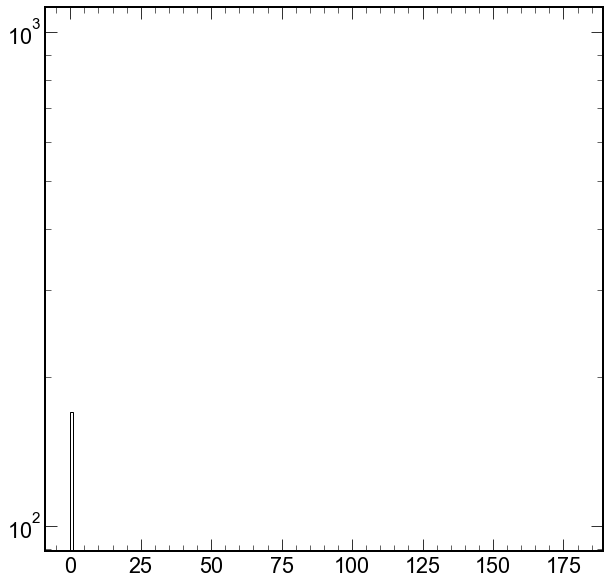

In [17]:
counts, bins = np.histogram(events.array('nTracks').flatten(),bins=180, range=(0,180))
plt.style.use(hep.style.ROOT)
plt.hist(counts, bins=bins, log=True,histtype='step', color='black')



0

## Four prongs selection


In [114]:
start = 0
stop  = 300000
itsl0 = events.array("HasPointOnITSLayer0", entrystart=start, entrystop=stop)
itsl1 = events.array("HasPointOnITSLayer1", entrystart=start, entrystop=stop)
tpcref = events.array("StatusAndTPCRefit", entrystart=start, entrystop=stop)
itcref = events.array("StatusAndITSRefit", entrystart=start, entrystop=stop)
dca0 = events.array("dca0", entrystart=start, entrystop=stop)
dca1 = events.array("dca1", entrystart=start, entrystop=stop)
tpcncls = events.array("TPCNcls", entrystart=start, entrystop=stop)
sigmtpcpion = events.array("NumberOfSigmasTPCPion", entrystart=start, entrystop=stop)
pt = events.array("Pt", entrystart=start, entrystop=stop)
px = events.array("Px", entrystart=start, entrystop=stop)
py = events.array("Py", entrystart=start, entrystop=stop)
pz = events.array("Pz", entrystart=start, entrystop=stop)
q = events.array("charge", entrystart=start, entrystop=stop)
entries = len(q)
# TODO: why tpcref freq value is 64?
select = ((itsl0 == 1) + (itsl1 == 1)) * (tpcref > 0) * (itcref > 0) * ((np.abs(dca0) < 3) + (np.abs(dca1) < 3)) * (tpcncls > 50) * (np.abs(sigmtpcpion) < 3)

GoodEvents = np.argwhere(np.sum(select,axis=1)==4)
GoodTracks = np.argwhere(select[GoodEvents.flatten()]==True).reshape(len(GoodEvents),8)
GoodEventsAndTracks = np.append(GoodEvents,GoodTracks[:,1:len(GoodTracks):2], axis=1) # array([[ 389,    2,    3,    5,    7],...])
GoodEventsNumber = GoodEventsAndTracks[:,0]
GoodTracksNum = GoodEventsAndTracks[:,1:]
print(f'Numer of events with 4pr: {len(GoodEventsNumber)}')

Numer of events with 4pr: 4220


Transversal momentum distribution for ccup9 trigger:

<ipython-input-115-d64eafff2e64>:13: RuntimeWarning: divide by zero encountered in floor_divide
  ax.errorbar(bins[:-1],counts, 10 * counts // counts,fmt='o', color='black',label=f'Entries {np.sum(counts)}')


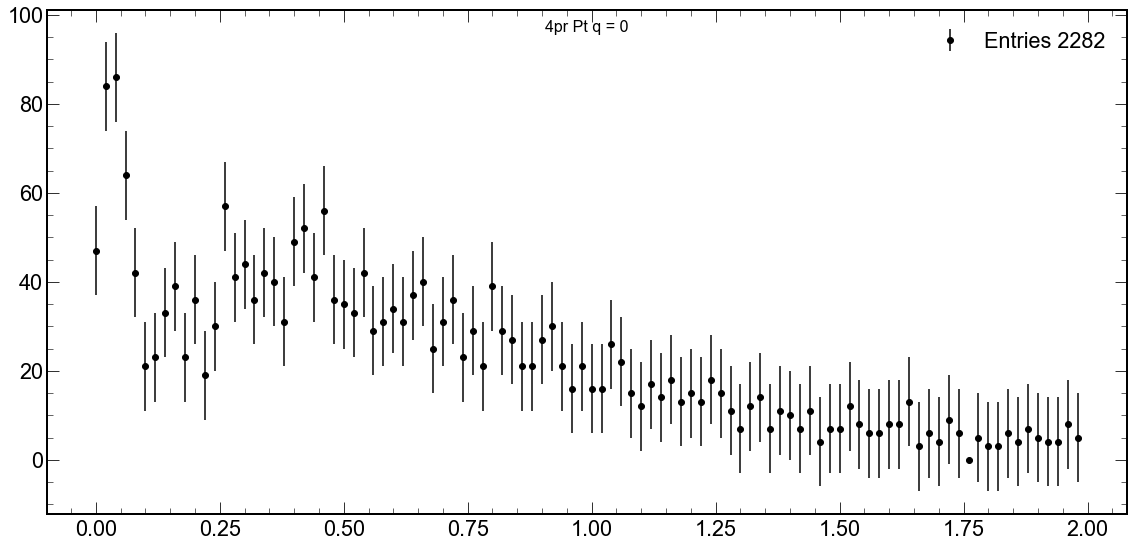

In [115]:
pxg = px[GoodEventsNumber][select[np.sum(select,axis=1)==4,:]].reshape(len(GoodEventsNumber),4)
pyg = py[GoodEventsNumber][select[np.sum(select,axis=1)==4,:]].reshape(len(GoodEventsNumber),4)
pzg = pz[GoodEventsNumber][select[np.sum(select,axis=1)==4,:]].reshape(len(GoodEventsNumber),4)

goodCharges = q[GoodEventsNumber][select[np.sum(select,axis=1)==4,:]].reshape(len(GoodEventsNumber),4)
goodChargesEventNumbers = np.argwhere(np.sum(goodCharges,axis=1)==0)
ptMy = np.sqrt(np.sum(np.add(np.sum(pxg[goodChargesEventNumbers], axis=2)**2, np.sum(pyg[goodChargesEventNumbers], axis=2)**2),axis=1))
counts, bins = np.histogram(ptMy,bins=100, range=(0,2))
fig = plt.figure(figsize=(15, 7))
ax = fig.add_axes([0,0,1,1])
fig.suptitle('4pr Pt q = 0', fontsize=16)
plt.style.use(hep.style.ROOT)
ax.errorbar(bins[:-1],counts, 10 * counts // counts,fmt='o', color='black',label=f'Entries {np.sum(counts)}')

ax.legend()


## Mass

<ipython-input-116-40b2d914db2e>:24: RuntimeWarning: divide by zero encountered in floor_divide
  ax.errorbar(bins[:-1],counts, 30 * counts // counts,fmt='o', color='black',label=f'Entries {np.sum(counts)}')


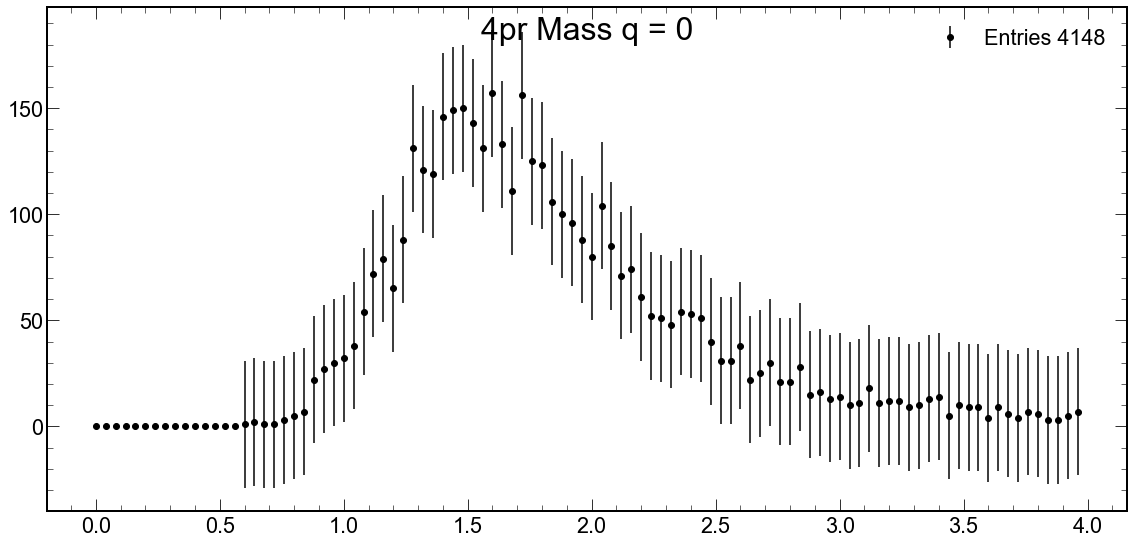

In [116]:
massPion = np.full(pxg.shape[0], 0.140)

# float esum = sqrt( (trk[0]->Px())*trk[0]->Px() + (trk[0]->Py())*trk[0]->Py() +(trk[0]->Pz())*trk[0]->Pz() + partmass*partmass);
# esum = esum + sqrt( (trk[1]->Px())*trk[1]->Px() + (trk[1]->Py())*trk[1]->Py() +(trk[1]->Pz())*trk[1]->Pz() + partmass*partmass);
# float amass = sqrt( esum*esum - pxsum*pxsum - pysum*pysum - pzsum*pzsum );


Energy0 = np.sqrt(massPion**2 + pxg[:,0]**2 + pyg[:,0]**2 + pzg[:,0]**2)
Energy1 = np.sqrt(massPion**2 + pxg[:,1]**2 + pyg[:,1]**2 + pzg[:,1]**2)
Energy2 = np.sqrt(massPion**2 + pxg[:,2]**2 + pyg[:,2]**2 + pzg[:,2]**2)
Energy3 = np.sqrt(massPion**2 + pxg[:,3]**2 + pyg[:,3]**2 + pzg[:,3]**2)

Energy = Energy0 + Energy1 + Energy2 + Energy3

Mass = np.sqrt(Energy**2 - np.sum(pxg,axis=1)**2 - np.sum(pyg,axis=1)**2 - np.sum(pzg,axis=1)**2)



counts, bins = np.histogram(Mass,bins=100, range=(0,4))
fig = plt.figure(figsize=(15, 7))
ax = fig.add_axes([0,0,1,1])
fig.suptitle('4pr Mass q = 0', fontsize=32)
plt.style.use(hep.style.ROOT)
ax.errorbar(bins[:-1],counts, 30 * counts // counts,fmt='o', color='black',label=f'Entries {np.sum(counts)}')

ax.legend()


## DRAFTS

Here I will move analysis to my own data:

In [1]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import mplhep as hep
import pandas as ps
import awkward

ccup9_2015_my_test = r"D:\GoogleDrive\Job\cern\Alice\analysis\dev\grid\selection\RhoPrime\macro\AnalysisResults.root"
ccup9_2015_my = r'D:\GoogleDrive\Job\cern\Alice\analysis\data\RhoPrime\2015\RhoPrime2015o.root'

events = uproot.open(ccup9_2015_my)['RhoPrimeCentral/events']
entries = events.numentries
events.show()
print(events.name, events.title, events.numentries)

# mycache = uproot.ArrayCache(1024*1024 * 10)
data = events.arrays('*', namedecode="utf-8")
data['nTracks'].sum() # 2 652 742 wo limitation # 208 039 with 177 tracks limitation


# b'events' b'Selected events for 4proungs analysis' 31 selected tracks 194 with limitation up to 200 tracks events. pt has  17 events 
# b'events' b'Selected events for 4proungs analysis' 47 selected tracks 317 without limitation. pt has  17 events 


RunNum                     (no streamer)              asdtype('>i4')
PeriodNumber               (no streamer)              asdtype('>u4')
OrbitNumber                (no streamer)              asdtype('>u4')
BunchCrossNumber           (no streamer)              asdtype('>u2')
Mass                       (no streamer)              asdtype('>f4')
Pt                         (no streamer)              asdtype('>f4')
Q                          (no streamer)              asdtype('>i2')
Rapidity                   (no streamer)              asdtype('>f4')
Phi                        (no streamer)              asdtype('>f4')
ZNAenergy                  (no streamer)              asdtype('>f4')
ZNCenergy                  (no streamer)              asdtype('>f4')
ZPAenergy                  (no streamer)              asdtype('>f4')
ZPCenergy                  (no streamer)              asdtype('>f4')
VtxX                       (no streamer)              asdtype('>f4')
VtxY                       (no str

3757097

2789


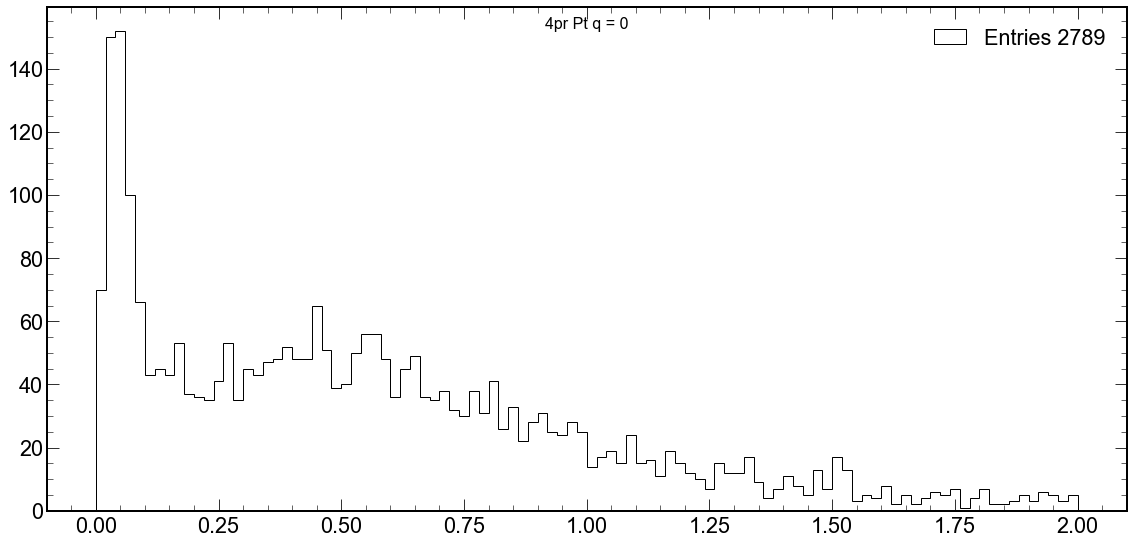

In [79]:
select = ((data['T_HasPointOnITSLayer0']) + (data['T_HasPointOnITSLayer1'])) * data['T_ITSRefit'] * data['T_TPCRefit'] * (data['T_TPCNCls'] > 50)  * (np.abs(data['T_NumberOfSigmaTPCPion']) < 3) #* ((np.abs(data['T_Dca1']) < 3)) # + (np.abs(data['T_Dca1']) < 3))
# get only events with 4 tracks
GoodEvents = np.argwhere(select.sum()==4)
# get events that have total zero charge from 4 tracks 
GoodEvents = GoodEvents[np.argwhere(data['T_Q'][GoodEvents.flatten()].sum()==0).flatten()].flatten()
GoodEvents = GoodEvents[np.argwhere(data['IsCUP11'][GoodEvents.flatten()]==False).flatten()].flatten()

pxg = data['T_Px'][GoodEvents][select[GoodEvents]]
pyg = data['T_Py'][GoodEvents][select[GoodEvents]]
pzg = data['T_Pz'][GoodEvents][select[GoodEvents]]

pt = np.sqrt(pxg.sum()**2  + pyg.sum()**2)
counts, bins = np.histogram(pt,bins=100, range=(0,2))
fig = plt.figure(figsize=(15, 7))
ax = fig.add_axes([0,0,1,1])
fig.suptitle('4pr Pt q = 0', fontsize=16)
plt.style.use(hep.style.ROOT)
ax.hist(pt, bins=bins, histtype='step', color='black', label=f'Entries {np.sum(counts)}')
ax.legend()
print (counts.sum())

# 51 fitted events without limitations on tracks 

array([1.79358751, 1.83408879, 1.46227175, 1.79320683, 2.21863957,
       2.28526578, 1.25106288, 1.45456169, 1.86202795, 1.33853569,
       1.48633003, 0.98564613, 2.30459369, 1.78509776, 1.78222396,
       1.46112869, 1.56698778, 1.57845359, 1.54046028, 1.59665144,
       1.69567862, 1.53294795, 1.39475973, 1.60816637, 1.4645652 ,
       1.77504307, 1.93601751, 1.37026325, 1.51996321, 1.36037154,
       1.59838346, 1.62206139, 1.32647488, 1.22845759, 1.10515356,
       2.184433  , 1.60418182, 1.70523222, 1.69156342, 1.54077528,
       2.03587798, 1.67232463, 1.45868563, 1.83949435, 1.52587441,
       2.66027256, 1.78890134, 1.43195009, 1.62762704, 1.68632208,
       1.59057152, 1.63825712, 1.67565479, 2.21363512, 1.49136286,
       1.27917022, 1.27695236, 2.04427037, 1.55364803, 1.74904906,
       1.8910237 , 2.04171543, 1.693615  , 0.90200426, 1.37378932,
       1.14621544, 1.47632082, 1.92998765, 1.695509  , 2.12474426,
       1.58046326, 1.26614323, 1.85799112, 2.04837415, 1.66426

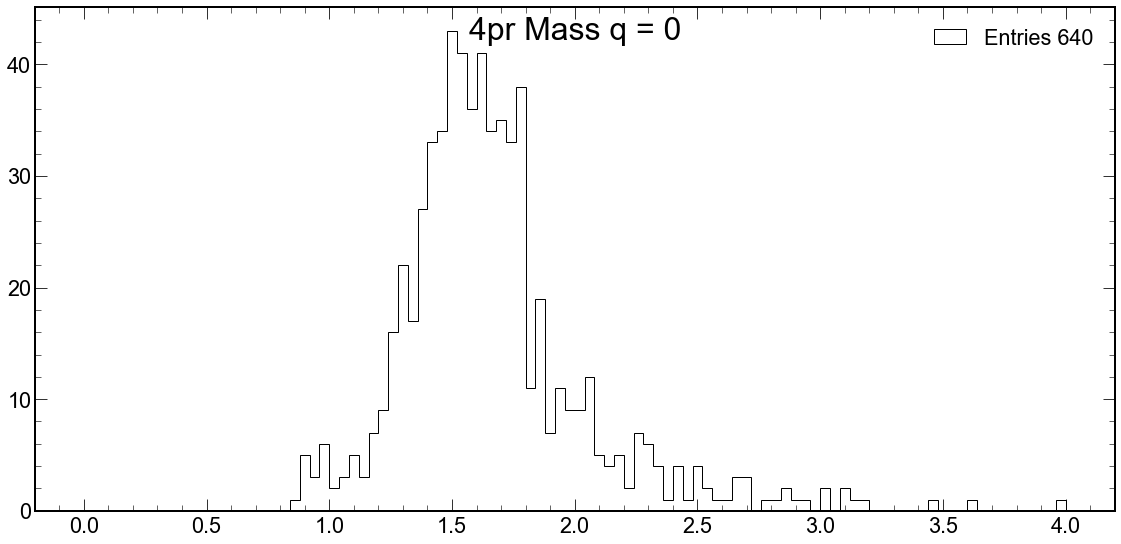

In [84]:
massPion = np.full(pxg.shape[0], 0.140)

# float esum = sqrt( (trk[0]->Px())*trk[0]->Px() + (trk[0]->Py())*trk[0]->Py() +(trk[0]->Pz())*trk[0]->Pz() + partmass*partmass);
# esum = esum + sqrt( (trk[1]->Px())*trk[1]->Px() + (trk[1]->Py())*trk[1]->Py() +(trk[1]->Pz())*trk[1]->Pz() + partmass*partmass);
# float amass = sqrt( esum*esum - pxsum*pxsum - pysum*pysum - pzsum*pzsum );

Energy0 = np.sqrt(massPion**2 + pxg[:,0]**2 + pyg[:,0]**2 + pzg[:,0]**2)
Energy1 = np.sqrt(massPion**2 + pxg[:,1]**2 + pyg[:,1]**2 + pzg[:,1]**2)
Energy2 = np.sqrt(massPion**2 + pxg[:,2]**2 + pyg[:,2]**2 + pzg[:,2]**2)
Energy3 = np.sqrt(massPion**2 + pxg[:,3]**2 + pyg[:,3]**2 + pzg[:,3]**2)

Energy = Energy0 + Energy1 + Energy2 + Energy3


Mass = np.sqrt(Energy**2 - pxg.sum()**2 - pyg.sum()**2 - pzg.sum()**2)[(pt<0.15)]
counts, bins = np.histogram(Mass,bins=100, range=(0,4))
fig = plt.figure(figsize=(15, 7))
ax = fig.add_axes([0,0,1,1])
fig.suptitle('4pr Mass q = 0', fontsize=32)
plt.style.use(hep.style.ROOT)
ax.hist(Mass, bins=bins, color='black', histtype='step', label=f'Entries {np.sum(counts)}')

ax.legend()
Mass

In [54]:
pt


array([0.7873966 , 0.21998332, 1.2867941 , ..., 0.02432011, 0.06014089,
       0.5556887 ], dtype=float32)

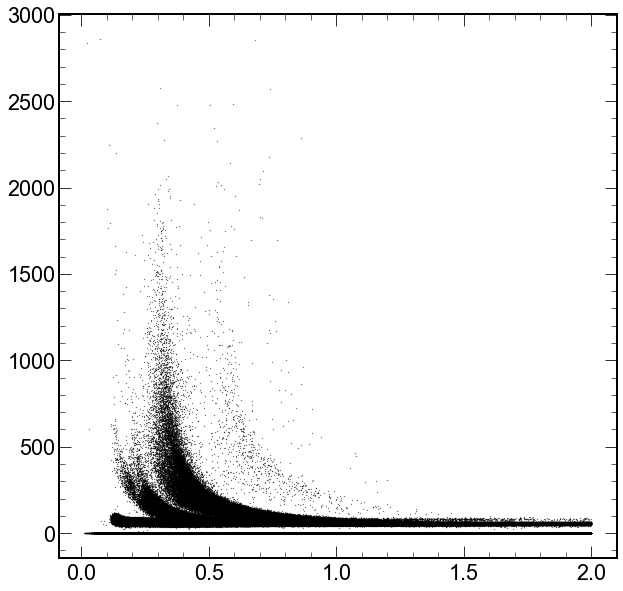

In [19]:
pt = np.sqrt(data['T_Px']**2 + data['T_Py']**2)#[(np.abs(data['T_NumberOfSigmaTPCPion']) < 3)]
dedx = data['TPCsignal'][(pt<2)]#[(np.abs(data['T_NumberOfSigmaTPCPion']) < 3)]
pt = pt[pt<2]
plt.style.use(hep.style.ROOT)
plt.scatter(pt.flatten(), dedx.flatten(),color='black',s=0.05)

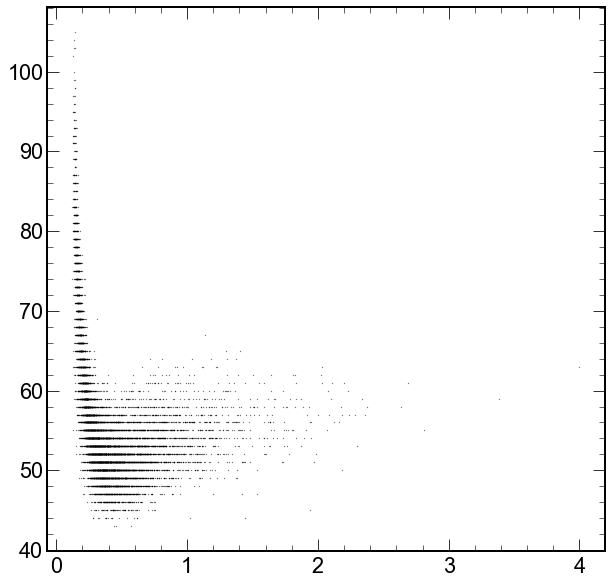

In [94]:

pxg = data['T_Px'][GoodEvents][select[GoodEvents]]
pyg = data['T_Py'][GoodEvents][select[GoodEvents]]
ptTracks = np.sqrt(pxg**2  + pyg**2)
dedx = data['TPCsignal'][GoodEvents][select[GoodEvents]]
plt.style.use(hep.style.ROOT)
plt.scatter(ptTracks.flatten(), dedx.flatten(),color='black',s=0.05)

In [93]:
len(dedx.flatten())

11500